# Information Retrieval - Corpus Filtering  
This notebook retrieves abstracts relevant to pandemics and then uses topic modeling to analyze the chosen abstracts.  Two info retrieval techniques are used: Literal Term Matching and Latent Semantic Indexing.  These are linear algebra techniques.  
We use the Scikit-Learn library.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)

import numpy as np
import pickle
import matplotlib.pyplot as plt
import gensim
import time

from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

#import spacy
#from spacy.lang.en.stop_words import STOP_WORDS

In [2]:
# pull in data

# full corpus
df = pd.read_pickle("../../../../data/prd/Tech-Report/FR_meta_and_final_tokens_21SEPT14.pkl")
df.reset_index(inplace = True)

# pandemics corpus
#df = pd.read_pickle("pandemic_corpus.pkl")
#df.reset_index(inplace = True)
#df.rename(columns={'index':'original index'}, inplace=True)

In [3]:
df.head()

,index,original index,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,final_tokens
0,0,0,89996,"This is a project to explore Game-based, Metap...",2008,Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,8/31/2012,"REESE, DEBBIE D","CARTER, BEVERLY; WOOD, CHARLES; HITT, BEN",01,068719400,WHEELING JESUIT UNIVERSITY,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008,1999467.0,NaN,1,1,"[project, explore, game, base, metaphor, enhan..."
1,1,1,89997,Institution: Franklin Institute Science Museum...,2008,Active Learning; Child; Computer software; des...,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,NSF,NSF,NaN,0741659,9/15/2008,8/31/2012,"SNYDER, STEVEN","ELINICH, KAREN; YOON, SUSAN",02,001741859,FRANKLIN INSTITUTE,PHILADELPHIA,PA,19103-1115,UNITED STATES,NaN,NaN,47.076,2008,1799699.0,NaN,1,1,"[institution, franklin_institute, science, mus..."
2,2,2,89998,Through programs (including small group conver...,2008,Address; Age; Birth; Brain; Caregivers; Child;...,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,NSF,NSF,NaN,0813522,9/15/2008,8/31/2011,"FINK, LAURIE KLEINBAUM","CADIGAN, KAREN; ELLENBOGEN, KIRSTEN",04,061451670,SCIENCE MUSEUM OF MINNESOTA,SAINT PAUL,MN,55102-1202,UNITED STATES,NaN,NaN,47.076,2008,1505858.0,NaN,1,1,"[program, small, group, conversation, citizen,..."
3,3,3,89999,In partnership with the American Chemical Soci...,2008,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,12/31/2010,"JOST, JOHN W","MILLER, BRADLEY; BOWMAN, KATHERINE",04,009059242,INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008,51000.0,NaN,1,1,"[partnership, american, chemical, society, acs..."
4,4,5,90001,The Center for Molecular Interfacing (CMI) wil...,2008,Address; Architecture; Carbon Nanotubes; Catal...,CCI PHASE I: CENTER FOR MOLECULAR INTERFACING,NSF,NSF,NaN,0847926,10/1/2008,9/30/2011,"ABRUNA, HECTOR D",NaN,22,872612445,CORNELL UNIVERSITY ITHACA,ITHACA,NY,14850-2820,UNITED STATES,NaN,NaN,47.049,2008,1519821.0,NaN,1,1,"[center, molecular, interfacing, cmi, enable, ..."


In [4]:
# input needed for doc-term matrix creation in Scikit-Learn is one string per document (not a list of strings).  
# Original data 'ABSTRACT' is already in this form, but not the tokens in "final_frqwds_removed"


tokens = df['final_tokens']   #df["stopwds_removed"]

docs = [] # docs will contain the processed tokens in string form (1 string per abstract)

for abstract in tokens:
    docs.append(" ".join(abstract))
    
docs = pd.Series(docs)


#docs = df["ABSTRACT"]  # raw text


### Term Matching

In [5]:
# new approach to grab all "coronavirus" matches

term_match_idx = []

for i, abstract in enumerate(docs):
    if ('coronavirus' in abstract): 
        term_match_idx.append(i)
        

In [6]:
len(term_match_idx) 

541

### Helper Functions

In [7]:
# Create binary query vector 

def create_query(words, terms):
    
    # words: search query words
    # terms: terms in corpus
    
    q = np.zeros(len(terms))  # number of terms

    idx = []
    for word in query_words:
        idx.append(terms.index(word))

    q[idx] = 1
    
    return q

In [8]:
def return_top_abstracts(scores, top_n):
    
    '''
    docs: Series that contains abstract
    scores: scores of abstracts
    top_n: return the top_n abstracts given by idx, if top_n = -1 return all abstracts
    '''
    # sort scores in descending order
    scores_sorted_idx = np.argsort(scores)[::-1]
    
    if top_n == -1:
        n = sum(scores > 0)
        ix = scores_sorted_idx[:n]
    else:
        ix = scores_sorted_idx[:top_n]
    
    #print(ix[0:10])
    
    return ix
    

In [9]:
def create_result_df(abstracts, scores):
    
    df = pd.DataFrame()
    df["abstracts"] = abstracts
    df["scores"] = scores
    
    return df

In [10]:
# Find doc-term matrix using TF-IDF weighting

tf_idf_vectorizer = TfidfVectorizer()
tf_idf = tf_idf_vectorizer.fit_transform(docs)

tf_idf_terms = tf_idf_vectorizer.get_feature_names()

In [11]:
len(tf_idf_terms)

1278210

In [12]:
count = 0

for term in tf_idf_terms:
    if 'coronavirus' in term:
        print(term)
        count = count + 1
        
print(count)

abetacoronavirus
acoronavirus
andcoronaviruse
anycoronavirus
arecoronavirus
ascoronaviruse
bat_coronaviruse
beta_coronavirus
betacoronavirus
betacoronaviruse
carriedcoronavirus
coronavirus
coronavirus_cov
coronavirus_hcov
coronavirus_hcov_emc
coronavirus_mers_cov
coronavirus_nl63
coronavirus_papain
coronavirus_sar
coronavirus_sar_cov
coronavirus_sars
coronavirus_sars_cov
coronavirus_spike
coronavirusand
coronaviruse
coronaviruse_cov
coronaviruse_hcov
coronaviruses
coronavirusesinteract
forcoronavirus
gammacoronavirus
manycoronavirus
mers_coronavirus
neurotropic_coronavirus
ofcoronaviruse
othercoronaviruse
pan_anticoronavirus
pan_coronavirus
peritonitiscoronavirus
respiratorycoronavirus
sar_coronavirus
sar_coronavirus_sar_cov
sars_coronavirus
sars_coronavirus_sars_cov
syndrome_coronavirus_mers
syndromecoronavirus
thatcoronaviruse
thecoronavirus
tractable_sar_coronavirus
49


In [13]:
# Find doc-term matrix for word cloud

vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(docs)

terms = vectorizer.get_feature_names()

In [14]:
dtm.shape

(696093, 1278210)

In [15]:
term_counts = dtm.sum(axis=0)

In [16]:
d = {}

for i, term in enumerate(terms):
    if 'coronavirus' in term:
        #print(term)
        d[term] = term_counts[0,i]

In [17]:
d

{'abetacoronavirus': 1,
 'acoronavirus': 1,
 'andcoronaviruse': 1,
 'anycoronavirus': 1,
 'arecoronavirus': 4,
 'ascoronaviruse': 1,
 'bat_coronaviruse': 21,
 'beta_coronavirus': 4,
 'betacoronavirus': 18,
 'betacoronaviruse': 11,
 'carriedcoronavirus': 1,
 'coronavirus': 417,
 'coronavirus_cov': 12,
 'coronavirus_hcov': 5,
 'coronavirus_hcov_emc': 10,
 'coronavirus_mers_cov': 6,
 'coronavirus_nl63': 9,
 'coronavirus_papain': 6,
 'coronavirus_sar': 2,
 'coronavirus_sar_cov': 13,
 'coronavirus_sars': 7,
 'coronavirus_sars_cov': 48,
 'coronavirus_spike': 15,
 'coronavirusand': 5,
 'coronaviruse': 330,
 'coronaviruse_cov': 24,
 'coronaviruse_hcov': 14,
 'coronaviruses': 3,
 'coronavirusesinteract': 1,
 'forcoronavirus': 1,
 'gammacoronavirus': 1,
 'manycoronavirus': 1,
 'mers_coronavirus': 11,
 'neurotropic_coronavirus': 12,
 'ofcoronaviruse': 1,
 'othercoronaviruse': 1,
 'pan_anticoronavirus': 1,
 'pan_coronavirus': 1,
 'peritonitiscoronavirus': 1,
 'respiratorycoronavirus': 1,
 'sar_cor

In [18]:
len(d)

49

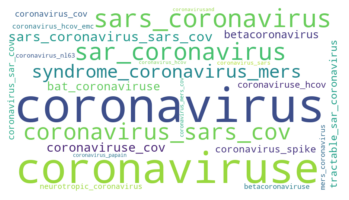

In [19]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=900, height= 500, scale=1, max_words = 25, background_color='white').generate_from_frequencies(d)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Latent Semantic Indexing (LSI)

In [20]:
# CHANGE QUERY WORDS HERE

query_words = []

for word in tf_idf_terms:
    if 'coronavirus' in word:
        query_words.append(word)

#query_words = ['pandemic', 'pandemics'] 
              
q = create_query(query_words, tf_idf_terms)

In [21]:
query_words

['abetacoronavirus',
 'acoronavirus',
 'andcoronaviruse',
 'anycoronavirus',
 'arecoronavirus',
 'ascoronaviruse',
 'bat_coronaviruse',
 'beta_coronavirus',
 'betacoronavirus',
 'betacoronaviruse',
 'carriedcoronavirus',
 'coronavirus',
 'coronavirus_cov',
 'coronavirus_hcov',
 'coronavirus_hcov_emc',
 'coronavirus_mers_cov',
 'coronavirus_nl63',
 'coronavirus_papain',
 'coronavirus_sar',
 'coronavirus_sar_cov',
 'coronavirus_sars',
 'coronavirus_sars_cov',
 'coronavirus_spike',
 'coronavirusand',
 'coronaviruse',
 'coronaviruse_cov',
 'coronaviruse_hcov',
 'coronaviruses',
 'coronavirusesinteract',
 'forcoronavirus',
 'gammacoronavirus',
 'manycoronavirus',
 'mers_coronavirus',
 'neurotropic_coronavirus',
 'ofcoronaviruse',
 'othercoronaviruse',
 'pan_anticoronavirus',
 'pan_coronavirus',
 'peritonitiscoronavirus',
 'respiratorycoronavirus',
 'sar_coronavirus',
 'sar_coronavirus_sar_cov',
 'sars_coronavirus',
 'sars_coronavirus_sars_cov',
 'syndrome_coronavirus_mers',
 'syndromecorona

In [22]:
len(query_words)

49

In [23]:
# Find the Truncated SVD of the TF-IDF matrix

lsa = TruncatedSVD(n_components=50, random_state=1)  # CHANGE THE NUMBER OF COMPONENTS - NOTE: MORE COMPONENTS 
                                                      # GIVES YOU A MORE ACCURATE APPROXIMATION OF THE DOC-TERM 
                                                      # MATRIX, BUT IS ALSO MORE EXPENSIVE AND MAY NOT LEAD TO THE 
                                                      # BEST INFO RETRIEVAL RESULTS.
USigma = lsa.fit_transform(tf_idf)
Vtrans = lsa.components_

In [24]:
S = lsa.singular_values_

In [25]:
S

array([126.2026823 ,  75.50207405,  58.61957317,  53.70609248,
        53.36235746,  48.98076647,  45.11536839,  42.34263352,
        39.78461328,  38.50170746,  37.75460958,  36.86680447,
        35.77699442,  34.187326  ,  33.6845451 ,  33.14176657,
        32.57960967,  31.90029149,  31.330768  ,  31.25763889,
        30.66783579,  30.32479277,  30.04793135,  29.6305617 ,
        29.09908964,  28.83356198,  28.7106275 ,  28.4572269 ,
        28.19216753,  27.92769557,  27.44585017,  27.20000949,
        26.65938306,  26.55558445,  26.18490167,  26.01166586,
        25.82502699,  25.64733363,  25.54309587,  25.39677687,
        25.18133438,  24.98979787,  24.84571794,  24.7454733 ,
        24.56094518,  24.36732609,  24.08132006,  23.84525827,
        23.57788701,  23.49980015])

In [26]:
# transform query to be in same space as documents

q = q.reshape(1,-1)  # changes (n,) vector to (1,n)
qhat = lsa.transform(q)

In [27]:
print(qhat.shape)
print(USigma.shape)
print(Vtrans.shape)

(1, 50)
(696093, 50)
(50, 1278210)


In [28]:
lsa_scores = cosine_similarity(qhat, USigma)  

In [29]:
sum(lsa_scores[0] > 0)

# 10: 447043
# 50: 376366   |  365991
# 100: 378149
# 150: 
# 200: 361772
# 500: 

365991

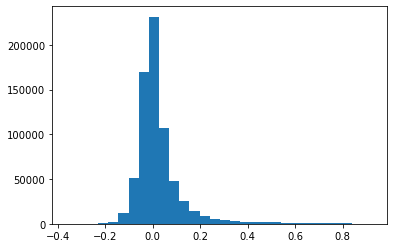

In [30]:
plt.hist(lsa_scores[0], bins = 30);
#plt.xlim(0.9, 1.1)

In [31]:
#np.percentile(lsa_scores[0], 93)

sum(lsa_scores[0] >= 0.5)#/len(lsa_scores[0])

# 10: 37846
# 50: 8454    | 8478
# 100: 3340
# 150: 
# 200: 1458
# 500: 

8478

In [32]:
np.percentile(lsa_scores[0], 99)

0.5438514208495933

In [33]:
500/len(lsa_scores[0])

0.0007182948255477357

In [34]:
lsa_idx = return_top_abstracts(lsa_scores[0], 500)  # CHANGE NUMBER OF TOP DOCS RETURNED
top_lsa_abstracts = docs[lsa_idx]

# top scores
lsa_scores[0][lsa_idx][0:10]

array([0.92406464, 0.92406464, 0.92406464, 0.92406464, 0.92406464,
       0.92406464, 0.92366568, 0.92232341, 0.92189915, 0.92189915])

In [39]:
top_lsa_abstracts[475:500]

153067    molecular interaction medically important arth...
326965    tick_bern_flaviviruse_tbfv belong family flavi...
58235     influenza virus iav significant human pathogen...
543732    grow concern naturally exist benign virus huma...
645927    hepatitis virus hev enterically transmit virus...
261633    influenza virus infection lung cause contagiou...
296776    etiology parkinson disease multivariate range ...
53031     mosquito host persistently_infect arthropod_be...
361224    transmit mosquitoe dengue important reemerge_i...
389417    influenza virus continue major threat global h...
448622    local site characteristic largely control tran...
496203    local site characteristic largely control tran...
83695     virus family paramyxoviridae contain number im...
530186    virus significant commercial application vecto...
97135     chronic infection hepatitis virus hbv affect a...
265913    hepatitis_c virus hcv positive strand rna viru...
160632    paramyxovirus family virus und

In [40]:
top_lsa_abstracts.iloc[10]

'chikungunya_virus_chikv_alphavirus togaviridae_family important anddangerous viral pathogen spread world recent year chikv causeschikungunya fever severe arthralgia persist month dengue virus denv_chikv arthropod_bern virus arbovirus currently license vaccine ordrug available human use chikungunya_virus recently develop novel technology base rational computer aid genedesign term synthetic_attenuated virus engineering save attenuate minusstrand rna virus poliovirus influenza virus dengue virus recode genome tointroduce unfavored codon pair codon pair deoptimize virus successfullyattenuated tissue culture animal model propose extend saveapproach emerge dangerous viral pathogen chikungunya_virus pursue theisolation attenuate viral strain aid computer tailoredalgorithms recode genome chikv contain large segment encode protein p4 e2_e1 codon pair dis favor mammal base previous study expect recode chik virus similarly attenuate andwill serve possible live vaccine candidate'

In [41]:
lsa_scores[0][lsa_idx][490:500]

array([0.82555099, 0.82499203, 0.82469718, 0.82469718, 0.82464396,
       0.82457311, 0.82429068, 0.82427733, 0.82418579, 0.82418579])

#### Scratch work for choosing rank of Truncated SVD in LSI

Note: ending indices should each be +1 more than they are.

In [42]:
print(len(set(lsa_idx) - set(term_match_idx)))  # worst possible: 2307

# 50: 
# 100: 
# 150: 
# 200: 1358
# 500: 

len(set(term_match_idx).intersection(set(lsa_idx)))

# 200: 750

481


19

In [36]:
#idx_50 = lsa_idx
#idx_100 = lsa_idx
#idx_150 = lsa_idx
idx_200 = lsa_idx
#idx_500 = lsa_idx

In [94]:
idx_50[0:50]

array([367176, 359975, 165083, 159197, 195614, 192354,  87187, 166197,
       184972, 180905, 374680, 190758, 374655, 476818, 171274, 568853,
       459330,  86152, 144080, 668292, 152978, 322361, 476180, 538655,
       532055,  84518, 182902, 667807, 157238, 191261, 180040, 183565,
       128226, 157053, 166876, 149957, 185250, 179546, 197965, 186328,
       193129, 190281, 268571, 144236, 669417, 684269,  42243,  42640,
       161305, 316242])

In [95]:
idx_100[0:50]

array([656975, 532055, 359975, 459330, 193129, 185250, 197965, 190281,
       179546, 186328, 367176, 161305,  86152, 374655,  62424, 142717,
       143762, 153784, 575566, 195614, 669417, 192354, 165083, 159197,
       183565, 414286, 682087, 374680, 190758, 188496, 322361, 538655,
       477013, 180905, 476818, 658186, 320839, 167280, 231632,  83536,
       541212, 165820,  16487, 157676, 541197, 530525, 424368, 152028,
       160659, 141163])

In [96]:
idx_150[0:50]

array([656975, 532055,  62424, 494325, 506772, 142717, 197965, 179546,
       185250, 193129, 186328, 190281, 575566, 477013, 161305, 682087,
       414286, 658186, 231632, 160659, 152028, 141163, 666335, 143762,
       530525, 153784, 634389, 655408, 659636, 532037, 201626, 280520,
       374655, 658791, 459330, 658997,  26944, 532890, 533383, 157676,
       655518, 174376, 367176, 386563, 359975, 536105, 169713, 188496,
       165820, 607701])

In [37]:
idx_200[0:50]

array([251567, 694614, 400298, 312429,  63939, 686135, 450560, 181224,
       120973, 187716, 259114,  50405, 226490,  50465, 691128, 253153,
       253072, 456505, 428232, 549592, 503734, 586295, 687086, 124010,
        52086, 157425, 321654, 296776,  41918, 527529, 509432, 321751,
       644592, 382461, 116918, 630413, 486450, 545306, 690188, 256396,
       510252,  39172, 328393, 647298, 113438, 123684, 187309, 115512,
       145686,  43995])

In [98]:
idx_500[0:50]

array([656975, 532055, 494325, 506772, 477013, 201626, 634389, 659636,
        26944, 658186, 655408, 530525, 575566, 585717, 658997, 553218,
        62424, 308156, 658791, 459220, 256803, 258900, 666335, 193129,
       197965, 190281, 179546, 186328, 185250, 659738, 519707, 406123,
       231632, 280520, 217136, 524203, 477077, 414286, 682087, 422364,
       257015,  91293, 657896, 142717, 337268, 143762, 153784,  30019,
       157676,  17508])

In [99]:
#pickle.dump([idx_50, idx_100, idx_150, idx_200, idx_500], open('rank_test.sav','wb'))

In [ ]:
# import saved data
f = open('rank_test.sav', 'rb')
[idx_50, idx_100, idx_150, idx_200, idx_500] = pickle.load(f)
f.close()

In [100]:
print(len(set(idx_50[0:999]) - set(idx_100[0:999]))) 

print('--------')

print(len(set(idx_50[0:1999]) - set(idx_100[0:1999]))) 

318
--------
555


In [101]:
print(len(set(idx_50[0:999]) - set(idx_150[0:999])))
print(len(set(idx_100[0:999]) - set(idx_150[0:999])))

print('------------')

print(len(set(idx_50[0:1999]) - set(idx_150[0:1999])))
print(len(set(idx_100[0:1999]) - set(idx_150[0:1999])))

551
301
------------
956
530


In [102]:
print(len(set(idx_50[0:999]) - set(idx_200[0:999])))
print(len(set(idx_100[0:999]) - set(idx_200[0:999])))
print(len(set(idx_150[0:999]) - set(idx_200[0:999])))

print('--------')

print(len(set(idx_50[0:1999]) - set(idx_200[0:1999])))
print(len(set(idx_100[0:1999]) - set(idx_200[0:1999])))
print(len(set(idx_150[0:1999]) - set(idx_200[0:1999])))

592
370
95
--------
1231
856
389


In [103]:
print(len(set(idx_50[0:999]) - set(idx_500[0:999])))
print(len(set(idx_100[0:999]) - set(idx_500[0:999])))
print(len(set(idx_150[0:999]) - set(idx_500[0:999])))
print(len(set(idx_200[0:999]) - set(idx_500[0:999])))

print('--------')

print(len(set(idx_50[0:1999]) - set(idx_500[0:1999])))
print(len(set(idx_100[0:1999]) - set(idx_500[0:1999])))
print(len(set(idx_150[0:1999]) - set(idx_500[0:1999])))
print(len(set(idx_200[0:1999]) - set(idx_500[0:1999])))

611
399
133
55
--------
1259
888
433
85


In [43]:
lsa_scores[0][lsa_idx][499]

0.8241857915021549

In [120]:
# check overlap for the documents returned with cosine score > 0.5

#sum(lsa_scores[0] >= 0.5)

# 50: 9731
# 100: 3520
# 150: 1505
# 200: 1447
# 500: 1307

print(len(set(idx_150[0:1504]) - set(idx_200[0:1446])))
print(len(set(idx_150[0:1504]) - set(idx_500[0:1446])))
print(len(set(idx_200[0:1446]) - set(idx_500[0:1306])))

print('--------')

print(len(set(idx_150[0:1504]).intersection(set(idx_200[0:1446]))))
print(len(set(idx_150[0:1504]).intersection(set(idx_500[0:1306]))))
print(len(set(idx_500[0:1306]).intersection(set(idx_200[0:1446]))))

181
231
146
--------
1323
1216
1300


## Create filtered corpus

We use the results of our two information retrieval techniques to create a new, smaller corpus that only contains abstracts relevant to the query. 

In [44]:
docs_ix = np.concatenate([term_match_idx, lsa_idx]) 

In [45]:
docs_idx = np.unique(docs_ix)

In [46]:
docs_idx.shape

(1022,)

In [ ]:
# check where term-matching and lsi indices overlap

In [47]:
tm = set(term_match_idx)
lsi = set(lsa_idx)

In [48]:
both = tm.intersection(lsi)
print(len(both))

19


In [49]:
print(len(term_match_idx))
print(len(lsa_idx))

541
500


In [50]:
541-19

522

In [51]:
500-19

481

**create case-study corpuses**

In [52]:
filt_corpus = df.loc[docs_idx, :]

In [53]:
filt_corpus.shape

(1022, 31)

In [54]:
filt_corpus.to_pickle("./coronavirus_corpus.pkl")

#pandemic_corpus = pd.read_pickle("/home/kjl5t/dspg20RnD/data/final/dashboard_data/pandemic_corpus.pkl")
#pandemic_corpus.shape

In [55]:
lim_docs = filt_corpus["final_tokens"]

In [56]:
# input needed for LDA, NMF (all from Scikit-Learn) is one string per document (not a list of strings)

text = []

for token_list in lim_docs:
    text.append(" ".join(token_list))

In [57]:
len(lim_docs)

1022

## Topic Modeling with relevant pandemic abstracts

In [58]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [59]:
# Create a TF-IDF document-term matrix for the coronavirus corpus 

# TRY DIFFERENT PARAMETERS IN THE TF-IDF DOC-TERM MATRIX SET-UP

stop_wds = ['research', 'study', 'project']

nmf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=False, stop_words=stop_wds)

nmf_tf_idf = nmf_vectorizer.fit_transform(text)

In [60]:
nmf_tf_idf.shape

(1022, 5383)

In [61]:
# topic modeling with NMF

nmf_model = NMF(n_components=25, random_state=1)  # TRY DIFFERENT NUMBERS OF TOPICS
W = nmf_model.fit_transform(nmf_tf_idf)
H = nmf_model.components_

In [62]:
print_topics(nmf_model, nmf_vectorizer, 10)


Topic 0:
('replication', 1.3504304416929505)
('rna', 1.3350147577790858)
('protein', 1.3044787632797876)
('viral', 0.925376504588184)
('host', 0.8808893863796495)
('coronavirus', 0.6041805357556755)
('factor', 0.43241519900686276)
('interaction', 0.424789520618751)
('target', 0.3828641698156403)
('cellular', 0.3815882840222217)

Topic 1:
('immune', 1.467970151560196)
('polygenic', 0.9560642847423532)
('trait', 0.7515794304961743)
('regulate', 0.7200917388641046)
('response', 0.6022644709140813)
('protective', 0.554386742498629)
('immunity', 0.5458349271400872)
('kinetic', 0.48331884276384984)
('phenotype', 0.45168292040798785)
('diverse', 0.42309853774212347)

Topic 2:
('influenza', 1.6484545442026095)
('virus', 0.8963847487360438)
('1918', 0.5003029089630254)
('pandemic', 0.41679956759484527)
('human', 0.29324310617037447)
('strain', 0.27411014695712393)
('2009', 0.238825188046448)
('avian', 0.22227539485489564)
('autopsy', 0.20959839771050162)
('people', 0.2090064735820787)

Topic 3

In [63]:
docs_ix = term_match_idx 
docs_idx = np.unique(docs_ix)
docs_idx.shape

(541,)

In [64]:
# topic model with just term matching

filt_corpus2 = df.loc[docs_idx, :]
print(filt_corpus2.shape)

lim_docs = filt_corpus2["final_tokens"]
print(len(lim_docs))

(541, 31)
541


In [65]:
filt_corpus2.to_pickle("./term-match-corpus.pkl")

In [66]:
# input needed for LDA, NMF (all from Scikit-Learn) is one string per document (not a list of strings)

text = []

for token_list in lim_docs:
    text.append(" ".join(token_list))

In [67]:
# Create a TF-IDF document-term matrix for the pandemics corpus 

# TRY DIFFERENT PARAMETERS IN THE TF-IDF DOC-TERM MATRIX SET-UP

stop_wds = ['research', 'study', 'project']

nmf_vectorizer2 = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=True, stop_words=stop_wds)

nmf_tf_idf2 = nmf_vectorizer2.fit_transform(text)
print(nmf_tf_idf2.shape)

(541, 3855)


In [68]:
# topic modeling with NMF

nmf_model2 = NMF(n_components=25, random_state=1)  # TRY DIFFERENT NUMBERS OF TOPICS
W = nmf_model2.fit_transform(nmf_tf_idf2)
H = nmf_model2.components_

/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2020.11-py3.8/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [69]:
print_topics(nmf_model2, nmf_vectorizer2, 10)


Topic 0:
('rna', 1.464355889701537)
('protein', 1.1814201811880014)
('replication', 0.8500011524299423)
('coronavirus', 0.7820987316922132)
('viral', 0.7068812157307511)
('coronaviruse', 0.5634737824116579)
('structure', 0.5623802778729222)
('interaction', 0.5400634430941839)
('virus', 0.5321837497299398)
('genome', 0.5159597664004939)

Topic 1:
('immune', 0.8538781407110143)
('polygenic', 0.5890003829898199)
('trait', 0.4759151181918677)
('regulate', 0.44325961279094883)
('protective', 0.35607773674976523)
('response', 0.3522545701192746)
('immunity', 0.3485273823821013)
('kinetic', 0.3118172708740275)
('phenotype', 0.3055942283737496)
('diverse', 0.2765213259929522)

Topic 2:
('disease', 0.5550989954904901)
('lung', 0.5003308879716493)
('develop', 0.38154010001092203)
('prognostic_indicator', 0.36209806962503005)
('severity', 0.3295844610947636)
('model', 0.3251323044660871)
('respiratory', 0.32141537853691055)
('etiology', 0.31628348318099314)
('human', 0.3095617542273428)
('use', 

In [70]:
filt_corpus.head()

,index,original index,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,final_tokens
5122,5122,5608,95622,Host - virus interactions are greatly affected...,2008,Affect; Antiviral Agents; Area; Biochemical; D...,THE ROLE OF A HOST ION PUMP IN RNA VIRUS RECOM...,NSF,NSF,NaN,0817790,8/15/2008,7/31/2012,"NAGY, PETER D",NaN,00,007400724,UNIVERSITY OF KENTUCKY,LEXINGTON,KY,40506-0057,UNITED STATES,NaN,NaN,47.074,2008,612000.0,NaN,1,1,"[host, virus, interaction, greatly, affect, ex..."
13938,13938,15726,152221,AbstractThe American Society for Virology (ASV...,2008,abstracting; Acquired Immunodeficiency Syndrom...,"INTERNATIONAL CONGRESS OF VIROLOGY, ISTANBUL, ...",HHS,NIH,NIAID,1R13AI075719-01,2/1/2008,1/31/2009,"SAWICKI, DOROTHEA L",NaN,09,807418939,UNIVERSITY OF TOLEDO HEALTH SCI CAMPUS,TOLEDO,OH,436142595,UNITED STATES,2/1/2008,1/31/2009,93.855,2008,30000.0,NaN,1,1,"[american, society, virology_asv, wish, provid..."
14418,14418,17118,153617,DESCRIPTION (provided by applicant): Severe a...,2008,Abbreviations; Address; Alleles; Alphavirus; A...,SARS REVERSE GENETICS,HHS,NIH,NIAID,5R01AI059136-05,2/15/2004,1/31/2010,"BARIC, RALPH S",NaN,04,608195277,UNIVERSITY OF NORTH CAROLINA CHAPEL HILL,CHAPEL HILL,NC,275990001,UNITED STATES,2/1/2008,1/31/2010,93.855,2008,271608.0,NaN,1,1,"[severe, acute, respiratory, syndrome, life_th..."
14514,14514,17384,153888,DESCRIPTION (provided by applicant): Human cor...,2008,Acute; Age-Years; Antigens; Archives; base; Bi...,EPIDEMIOLOGY AND CLINICAL FEATURES OF HUMAN CO...,HHS,NIH,NIAID,5R03AI068069-02,2/1/2007,1/31/2010,"WILLIAMS, JOHN V",NaN,05,965717143,VANDERBILT UNIVERSITY,NASHVILLE,TN,372407749,UNITED STATES,2/1/2008,1/31/2010,93.855,2008,75292.0,NaN,1,1,"[human, coronaviruse_hcov, initially, identify..."
14565,14565,17526,154033,"DESCRIPTION: Plus-stranded RNA viruses, which ...",2008,Affect; Agriculture; Animals; Antiviral Agents...,ROLES OF HOST RNA BINDING PROTEINS IN VIRUS RE...,HHS,NIH,NIAID,5R21AI072170-02,2/1/2007,1/31/2010,"NAGY, PETER",NaN,06,939017877,UNIVERSITY OF KENTUCKY,LEXINGTON,KY,405260001,UNITED STATES,2/1/2008,1/31/2010,93.855,2008,200124.0,NaN,1,1,"[strand, rna, virus, pose, significant, risk, ..."
